# Importing packages

In [1]:
from workers import MasterNode
from models import LinReg, LogReg, LogRegNoncvx, NN_1d_regression
from utils import read_run, get_alg, create_plot_dir, PLOT_PATH
from sklearn.datasets import dump_svmlight_file, load_svmlight_file

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from prep_data import number_of_features, split_data, load_data
import math
import torch
from scipy.sparse import coo_matrix, hstack

from numpy.random import default_rng
from numpy import linalg as la
from prep_data import DATASET_PATH
import copy
import sys

# Customizing Matplotlib

In [2]:
plt.style.use('fast')
mpl.rcParams['mathtext.fontset'] = 'cm'
# mpl.rcParams['mathtext.fontset'] = 'dejavusans'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['axes.titlesize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['axes.labelsize'] = 'xx-large'

In [3]:
markers = ['x', '.', '+', '1', 'p','*', 'D' , '.',  's']

# w6a

## Splitting train dataset into train and validation

In [4]:
initial_dataset_name = 'w6a'
validation_proportion = 0.1

In [5]:
test_dataset_name = 'w6a.t'

In [6]:
while True:
    dataset_name, validation_dataset_name = split_data(initial_dataset_name, validation_proportion)
    print('----')
    print(load_svmlight_file(DATASET_PATH + dataset_name)[0].shape[1])
    print(load_svmlight_file(DATASET_PATH + validation_dataset_name)[0].shape[1])
    print('----')
    if load_svmlight_file(DATASET_PATH + dataset_name)[0].shape[1] == load_svmlight_file(DATASET_PATH + validation_dataset_name)[0].shape[1]:
        break

(15469, 300)
(1719, 300)
----
300
300
----


In [48]:
# parameters
n_workers = 16
alpha = 0.5
alg = LogReg
logreg = True
ordered = True
max_it = 200
compute_smoothness_min = True
tolerance = 1e-6
regularization = 0.1
fomaml_inner_loop_lr = 0.01
fomaml_outer_loop_lr = 0.1
gd_stepsize = fomaml_inner_loop_lr
fomaml_number_of_inner_steps = 4
reptile_inner_loop_lr = 0.01
reptile_outer_loop_lr = 0.1
reptile_number_of_inner_steps = 4
modexpmix_inner_loop_lr = 0.01
modexpmix_outer_loop_lr = 0.1
modexpmix_number_of_inner_steps = 4
sgd_mixed_outer_loop = 0.1
validation = True

In [49]:
model_log = MasterNode(n_workers=n_workers,
                      alpha=alpha,
                      worker=alg,
                      dataset_name=dataset_name,
                      logreg=logreg,
                      ordered=ordered,
                      max_it=max_it,
                      compute_smoothness_min=compute_smoothness_min,
                      tolerance=tolerance,
                      regularization=regularization,
                      validation=validation,
                      validation_dataset_name=validation_dataset_name,
                      fomaml_inner_loop_lr=fomaml_inner_loop_lr,
                      fomaml_outer_loop_lr=fomaml_outer_loop_lr,
                      fomaml_number_of_inner_steps=fomaml_number_of_inner_steps,
                      reptile_inner_loop_lr=reptile_inner_loop_lr,
                      reptile_outer_loop_lr=reptile_outer_loop_lr,
                      reptile_number_of_inner_steps=reptile_number_of_inner_steps,
                      modexpmix_inner_loop_lr=modexpmix_inner_loop_lr,
                      modexpmix_outer_loop_lr=modexpmix_outer_loop_lr,
                      modexpmix_number_of_inner_steps=modexpmix_number_of_inner_steps,
                      sgd_mixed_outer_loop=sgd_mixed_outer_loop
                      )

Before: 300
Before for val: (108, 300)
After: 301
self.x_validation shape = (108, 301)
Worker(logreg) 0 tolerance 1e-06
Learning rate is 1.25661363574142
   71/100000 Iterations: fun_value 0.286697 norm of the gradient 9.885526918659387e-076
Before: 300
Before for val: (108, 300)
After: 301
self.x_validation shape = (108, 301)
Worker(logreg) 1 tolerance 1e-06
Learning rate is 1.2304662972697806
   73/100000 Iterations: fun_value 0.280306 norm of the gradient 8.844954537375118e-076
Before: 300
Before for val: (108, 300)
After: 301
self.x_validation shape = (108, 301)
Worker(logreg) 2 tolerance 1e-06
Learning rate is 1.233359115793623
   74/100000 Iterations: fun_value 0.295904 norm of the gradient 8.84134987179918e-0706
Before: 300
Before for val: (108, 300)
After: 301
self.x_validation shape = (108, 301)
Worker(logreg) 3 tolerance 1e-06
Learning rate is 1.2024612519478366
   74/100000 Iterations: fun_value 0.280763 norm of the gradient 9.508877006169778e-076
Before: 300
Before for val:

/home/gasanoe/fed_mixture_code/models.py:217: RuntimeWarning: divide by zero encountered in log
  return -(np.where(y == 1, np.log(h), zeros) + np.where(y == 0, np.log(1-h), zeros)).mean()


  400/  400 Iterations: fun_value 0.291475


## Training models

In [50]:
epochs = 50
task_batch = 4
# data_batch_fomaml = int(0.7 * model_log.workers[0].x_train.shape[0])
# data_batch_reptile = int(0.7 * (model_log.workers[0].x_train.shape[0] + model_log.workers[0].x_validation.shape[0]))

In [51]:
fomaml_model = model_log.fomaml(epochs=epochs, task_batch=task_batch)

Running FOMAML.


In [52]:
reptile_model = model_log.reptile(epochs=epochs, task_batch=task_batch)

Running Reptile.


In [53]:
exp_model = model_log.sgd_mixed(epochs=epochs, task_batch=task_batch)

In [54]:
modexp_model = model_log.sgd_mixed_modified(epochs=epochs, task_batch=task_batch)

## Test dataset

In [55]:
test_data = load_data(test_dataset_name, n_workers, True, True)

In [56]:
test_data_modified = [] # intercept adding
for i in range(n_workers):
    x = test_data[i][0]
    y = test_data[i][1]
    ones = coo_matrix(np.ones((x.shape[0], 1)))
    x_ = hstack([ones, x])
    test_data_modified.append((x_, y))            

In [57]:
assert test_data_modified[0][0].shape[1] == model_log.workers[0].x_train.shape[1]

In [58]:
def model_local(model, w, k, inner_loop_lr):
    weights = copy.deepcopy(w) 
    for i in range(k):
        weights -= inner_loop_lr * model.grad(model.x_train, model.y_train, weights)
    return weights

In [59]:
def model_local_mixed(model, w_opt_global, k, inner_loop_lr):
    weights = copy.deepcopy(w_opt_global) 
    for i in range(k):
        weights -= inner_loop_lr * (1.0 - model.alpha) * model.grad(model.x_train, model.y_train, model.compute_local_modified(weights, w_opt_global))
    return model.compute_local_modified(weights, w_opt_global)

In [60]:
def _sigmoid(x):
    return 1.0 / (1 + np.exp(-x))
def logreg_loss(data, w):
    x, y = data
    y_pred = _sigmoid(x.dot(w))
    zeros = np.zeros_like(y_pred)
    return -(np.where(y == 1, np.log(y_pred), zeros) + np.where(y == 0, np.log(1 - y_pred), zeros)).mean()

In [62]:
ks = np.arange(11)
inner_step_lr = 0.01
assert inner_step_lr == fomaml_inner_loop_lr
loss_fomaml = np.empty(shape=(n_workers, len(ks)))
loss_reptile = np.empty(shape=(n_workers, len(ks)))
loss_exp = np.empty(shape=(n_workers))
loss_modexp = np.empty(shape=(n_workers, len(ks)))
for i in range(n_workers):
    loss_exp[i] = logreg_loss(test_data_modified[i], model_log.workers[i].compute_local(exp_model))
    for k in ks:
        curr_fomaml = model_local(model_log.workers[i], fomaml_model, k, inner_step_lr)
        curr_reptile = model_local(model_log.workers[i], reptile_model, k, inner_step_lr)
        curr_modexp = model_local_mixed(model_log.workers[i], modexp_model, k, inner_step_lr)
        loss_fomaml[i][k] = logreg_loss(test_data_modified[i], curr_fomaml)
        loss_reptile[i][k] = logreg_loss(test_data_modified[i], curr_reptile)
        loss_modexp[i][k] = logreg_loss(test_data_modified[i], curr_modexp)

In [67]:
import pandas as pd
import seaborn as sns

In [77]:
y_axis_name = 'log loss'
pd_fomaml = pd.DataFrame(loss_fomaml.flatten(), columns=[y_axis_name])
pd_reptile = pd.DataFrame(loss_reptile.flatten(), columns=[y_axis_name])
pd_modexp = pd.DataFrame(loss_modexp.flatten(), columns=[y_axis_name])
pd_exp = pd.DataFrame(np.repeat(loss_exp, len(ks)), columns=[y_axis_name])

x_axis_name = 'number of gradient steps'
pd_ks = pd.DataFrame(np.array([ks] * n_workers).flatten(), dtype=int)
pd_fomaml[x_axis_name] = pd_ks
pd_reptile[x_axis_name] = pd_ks
pd_modexp[x_axis_name] = pd_ks
pd_exp[x_axis_name] = pd_ks

curve_name = 'model'
pd_fomaml[curve_name] = 'FOMAML'
pd_reptile[curve_name] = 'Reptile'
pd_modexp[curve_name] = 'Modified Mixture'
pd_exp[curve_name] = 'Explicit Mixture'

all_data = pd.concat([pd_fomaml, pd_reptile, pd_modexp, pd_exp])

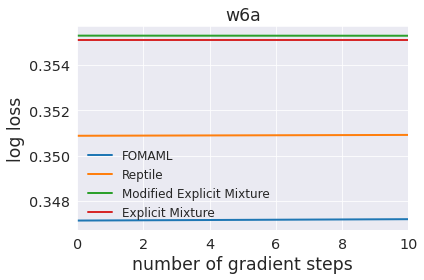

In [104]:
plt.figure()
sns.set_style('darkgrid')
plt.plot(ks, loss_fomaml.mean(axis=0), label = 'FOMAML')
plt.plot(ks, loss_reptile.mean(axis=0), label = 'Reptile')
plt.plot(ks, loss_modexp.mean(axis=0), label = 'Modified Explicit Mixture')
plt.plot(ks, [loss_exp[i].mean()] * len(ks), label = 'Explicit Mixture')
plt.legend(frameon=False)
plt.xlim(left=ks[0], right=ks[-1])
plt.xlabel('number of gradient steps')
plt.ylabel('log loss')
plt.title('w6a')
plt.tight_layout()
# plt.savefig(PLOT_PATH + '/w6a_comp.pdf')

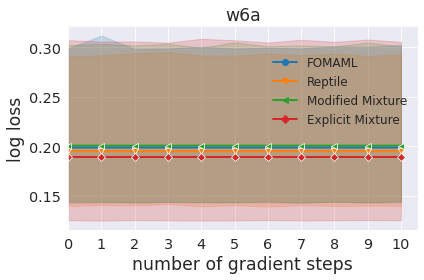

In [81]:
sns.set_style('darkgrid')
g = sns.lineplot(x=x_axis_name, y=y_axis_name, style=curve_name, hue=curve_name, 
                 dashes=False, markers=['o', 'v', '<', 'D'], data=all_data)
g.set(xlim=(0, None), xticks=ks)
g.legend_.draw_frame(False)
g.legend_.texts[0].set_text('')
# g.legend_.texts[3].set_text('Modified Mixture')
g.set_title('w6a')
plt.tight_layout()
# plt.savefig(PLOT_PATH + '/w6a_comp.pdf')

## Line graphs for all datasets

In [102]:
params = {}
params['n_workers'] = 16
params['alpha'] = 0.5
params['worker'] = LogReg
params['logreg'] = True
params['ordered'] = True
params['max_it'] = 200
params['compute_smoothness_min'] = True
params['tolerance'] = 1e-6
params['regularization'] = 0.1
params['fomaml_inner_loop_lr'] = 0.01
params['fomaml_outer_loop_lr'] = 0.1
params['fomaml_number_of_inner_steps'] = 4
params['reptile_inner_loop_lr'] = 0.01
params['reptile_outer_loop_lr'] = 0.1
params['reptile_number_of_inner_steps'] = 4
params['modexpmix_inner_loop_lr'] = 0.01
params['modexpmix_outer_loop_lr'] = 0.1
params['modexpmix_number_of_inner_steps'] = 4
params['sgd_mixed_outer_loop'] = 0.1
params['validation'] = True

In [107]:
epochs = 50
task_batch = 4
validation_proportion = 0.1

In [111]:
initial_dataset_names = ['splice', 'w6a', 'ijcnn1.bz2']
test_dataset_names = ['splice.t', 'w6a.t', 'ijcnn1.t.bz2']

splice , splice.t
Trying to successfully split dataset into train and validation...
(900, 60)
(100, 60)
----
60
60
----
Success.
Before: 60
Before for val: (7, 60)
After: 61
self.x_validation shape = (7, 61)
Worker(logreg) 0 tolerance 1e-06
Learning rate is 0.009743241972380703
 8864/100000 Iterations: fun_value 0.218532 norm of the gradient 9.989788402825776e-076
Before: 60
Before for val: (7, 60)
After: 61
self.x_validation shape = (7, 61)
Worker(logreg) 1 tolerance 1e-06
Learning rate is 0.010408429087143541
 8565/100000 Iterations: fun_value 0.266622 norm of the gradient 9.99935313213235e-0706
Before: 60
Before for val: (7, 60)
After: 61
self.x_validation shape = (7, 61)
Worker(logreg) 2 tolerance 1e-06
Learning rate is 0.010149838469014044
 8956/100000 Iterations: fun_value 0.290821 norm of the gradient 9.99893696407022e-0766
Before: 60
Before for val: (7, 60)
After: 61
self.x_validation shape = (7, 61)
Worker(logreg) 3 tolerance 1e-06
Learning rate is 0.010349304828236917
 9082/1

/home/gasanoe/fed_mixture_code/models.py:217: RuntimeWarning: divide by zero encountered in log
  return -(np.where(y == 1, np.log(h), zeros) + np.where(y == 0, np.log(1-h), zeros)).mean()


  400/  400 Iterations: fun_value 0.322621
Running FOMAML.
Running Reptile.
w6a , w6a.t
Trying to successfully split dataset into train and validation...
(15469, 300)
(1719, 300)
----
300
300
----
Success.
Before: 300
Before for val: (108, 300)
After: 301
self.x_validation shape = (108, 301)
Worker(logreg) 0 tolerance 1e-06
Learning rate is 1.0816276051261384
   85/100000 Iterations: fun_value 0.290202 norm of the gradient 8.946850653801828e-076
Before: 300
Before for val: (108, 300)
After: 301
self.x_validation shape = (108, 301)
Worker(logreg) 1 tolerance 1e-06
Learning rate is 1.2139094759320967
   74/100000 Iterations: fun_value 0.290713 norm of the gradient 9.460954636991612e-076
Before: 300
Before for val: (108, 300)
After: 301
self.x_validation shape = (108, 301)
Worker(logreg) 2 tolerance 1e-06
Learning rate is 1.283510839363599
   70/100000 Iterations: fun_value 0.296774 norm of the gradient 9.716285937897176e-076
Before: 300
Before for val: (108, 300)
After: 301
self.x_valida

/home/gasanoe/fed_mixture_code/models.py:217: RuntimeWarning: divide by zero encountered in log
  return -(np.where(y == 1, np.log(h), zeros) + np.where(y == 0, np.log(1-h), zeros)).mean()


  400/  400 Iterations: fun_value 0.291365
Running FOMAML.
Running Reptile.
ijcnn1.bz2 , ijcnn1.t.bz2
Trying to successfully split dataset into train and validation...
(44991, 22)
(4999, 22)
----
22
22
----
Success.
Before: 22
Before for val: (313, 22)
After: 23
self.x_validation shape = (313, 23)
Worker(logreg) 0 tolerance 1e-06
Learning rate is 3.303057082235437
   25/100000 Iterations: fun_value 0.435943 norm of the gradient 9.156378898466406e-076
Before: 22
Before for val: (313, 22)
After: 23
self.x_validation shape = (313, 23)
Worker(logreg) 1 tolerance 1e-06
Learning rate is 3.306729573228625
   25/100000 Iterations: fun_value 0.440899 norm of the gradient 8.939389048742372e-076
Before: 22
Before for val: (313, 22)
After: 23
self.x_validation shape = (313, 23)
Worker(logreg) 2 tolerance 1e-06
Learning rate is 3.2965396814629515
   25/100000 Iterations: fun_value 0.418550 norm of the gradient 8.006453981411679e-076
Before: 22
Before for val: (313, 22)
After: 23
self.x_validation s

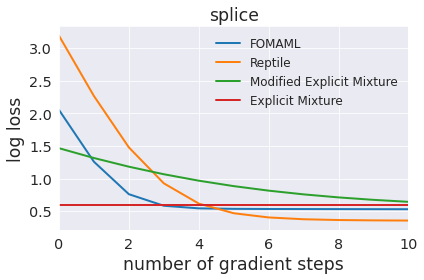

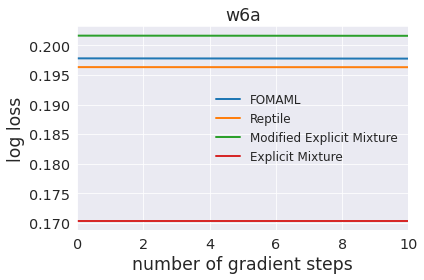

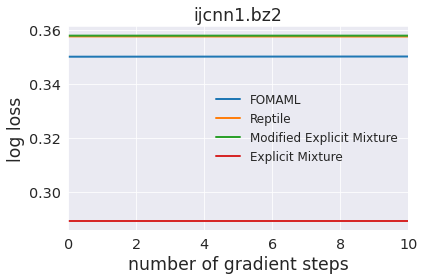

In [114]:
for i in range(len(initial_dataset_names)):
    initial_dataset_name = initial_dataset_names[i]
    test_dataset_name = test_dataset_names[i]
    print(initial_dataset_name, ',', test_dataset_name)
    print('Trying to successfully split dataset into train and validation...')
    while True:
        dataset_name, validation_dataset_name = split_data(initial_dataset_name, validation_proportion)
        print('----')
        print(load_svmlight_file(DATASET_PATH + dataset_name)[0].shape[1])
        print(load_svmlight_file(DATASET_PATH + validation_dataset_name)[0].shape[1])
        print('----')
        if load_svmlight_file(DATASET_PATH + dataset_name)[0].shape[1] == load_svmlight_file(DATASET_PATH + validation_dataset_name)[0].shape[1]:
            break
    print('Success.')
    params['dataset_name'] = dataset_name
    params['validation_dataset_name'] = validation_dataset_name
    model_log = MasterNode(**params)
    fomaml_model = model_log.fomaml(epochs=epochs, task_batch=task_batch)
    reptile_model = model_log.reptile(epochs=epochs, task_batch=task_batch)
    exp_model = model_log.sgd_mixed(epochs=epochs, task_batch=task_batch)
    modexp_model = model_log.sgd_mixed_modified(epochs=epochs, task_batch=task_batch)
    test_data = load_data(test_dataset_name, n_workers, True, True)
    test_data_modified = [] # intercept adding
    for i in range(n_workers):
        x = test_data[i][0]
        y = test_data[i][1]
        ones = coo_matrix(np.ones((x.shape[0], 1)))
        x_ = hstack([ones, x])
        test_data_modified.append((x_, y))  
    assert test_data_modified[0][0].shape[1] == model_log.workers[0].x_train.shape[1]
    ks = np.arange(11)
    inner_step_lr = 0.01
    assert inner_step_lr == params['fomaml_inner_loop_lr']
    loss_fomaml = np.empty(shape=(n_workers, len(ks)))
    loss_reptile = np.empty(shape=(n_workers, len(ks)))
    loss_exp = np.empty(shape=(n_workers))
    loss_modexp = np.empty(shape=(n_workers, len(ks)))
    for i in range(n_workers):
        loss_exp[i] = logreg_loss(test_data_modified[i], model_log.workers[i].compute_local(exp_model))
        for k in ks:
            curr_fomaml = model_local(model_log.workers[i], fomaml_model, k, inner_step_lr)
            curr_reptile = model_local(model_log.workers[i], reptile_model, k, inner_step_lr)
            curr_modexp = model_local_mixed(model_log.workers[i], modexp_model, k, inner_step_lr)
            loss_fomaml[i][k] = logreg_loss(test_data_modified[i], curr_fomaml)
            loss_reptile[i][k] = logreg_loss(test_data_modified[i], curr_reptile)
            loss_modexp[i][k] = logreg_loss(test_data_modified[i], curr_modexp)
    plt.figure()
    sns.set_style('darkgrid')
    plt.plot(ks, loss_fomaml.mean(axis=0), label = 'FOMAML')
    plt.plot(ks, loss_reptile.mean(axis=0), label = 'Reptile')
    plt.plot(ks, loss_modexp.mean(axis=0), label = 'Modified Explicit Mixture')
    plt.plot(ks, [loss_exp[i].mean()] * len(ks), label = 'Explicit Mixture')
    plt.legend(frameon=False)
    plt.xlim(left=ks[0], right=ks[-1])
    plt.xlabel('number of gradient steps')
    plt.ylabel('log loss')
    plt.title(initial_dataset_name)
    plt.tight_layout()
    plt.savefig(PLOT_PATH + '/{}_comp.pdf'.format(initial_dataset_name))

## Hyperparameter tuning

In [16]:
inner_loop_lrs = [0.1, 0.01, 0.001, 0.0001]
outer_loop_lrs = [0.1, 0.01, 0.001, 0.0001]
numbers_of_inner_steps = [4, 8, 16, 32]

In [23]:
np.linspace(0, 30, 10, dtype=int)

array([ 0,  3,  6, 10, 13, 16, 20, 23, 26, 30])

0.1 0.1 4
Running FOMAML.
Running Reptile.


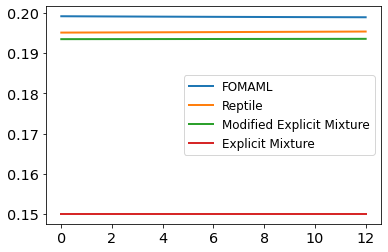

0.1 0.1 8
Running FOMAML.
Running Reptile.


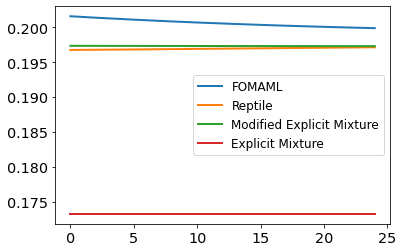

0.1 0.1 16
Running FOMAML.
Running Reptile.


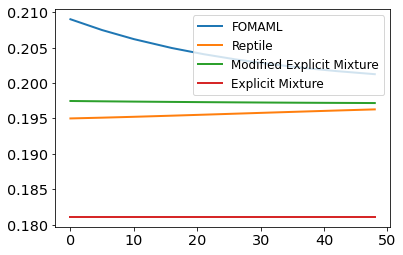

0.1 0.1 32
Running FOMAML.
Running Reptile.


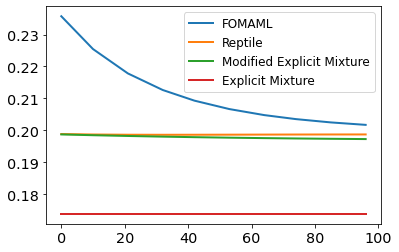

0.1 0.01 4
Running FOMAML.
Running Reptile.


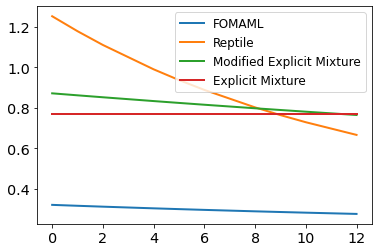

0.1 0.01 8
Running FOMAML.
Running Reptile.


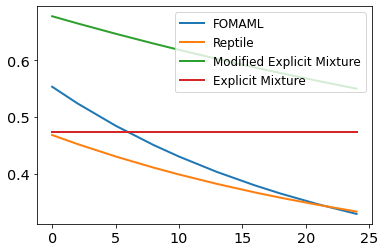

0.1 0.01 16
Running FOMAML.
Running Reptile.


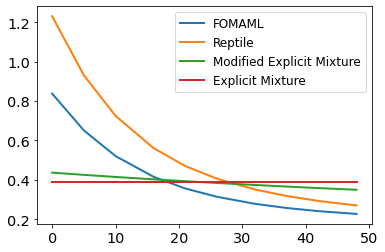

0.1 0.01 32
Running FOMAML.
Running Reptile.


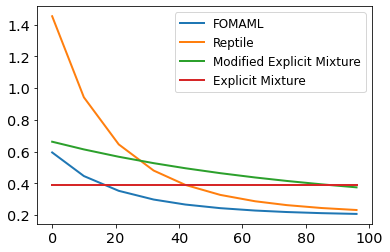

0.1 0.001 4
Running FOMAML.
Running Reptile.


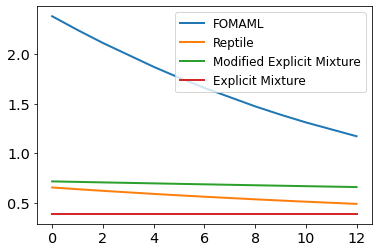

0.1 0.001 8
Running FOMAML.
Running Reptile.


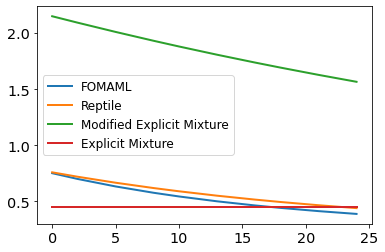

0.1 0.001 16
Running FOMAML.
Running Reptile.


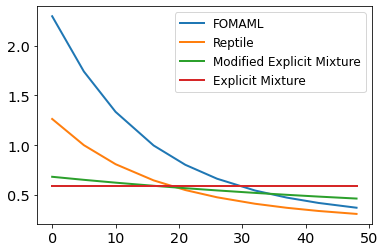

0.1 0.001 32
Running FOMAML.
Running Reptile.


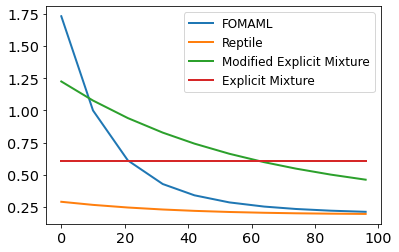

0.1 0.0001 4
Running FOMAML.
Running Reptile.


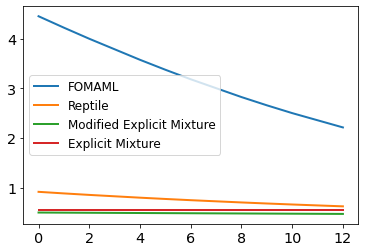

0.1 0.0001 8
Running FOMAML.
Running Reptile.


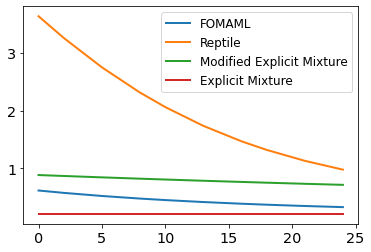

0.1 0.0001 16
Running FOMAML.
Running Reptile.


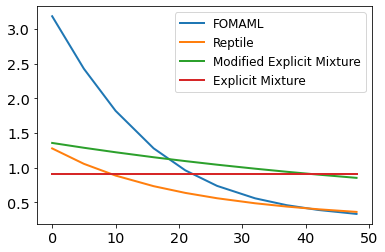

0.1 0.0001 32
Running FOMAML.
Running Reptile.


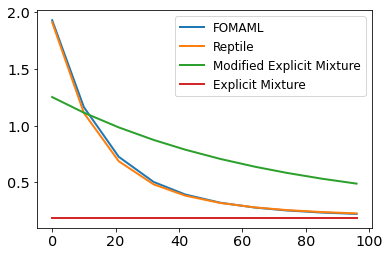

0.01 0.1 4
Running FOMAML.
Running Reptile.


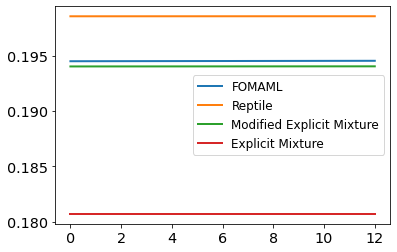

0.01 0.1 8
Running FOMAML.
Running Reptile.


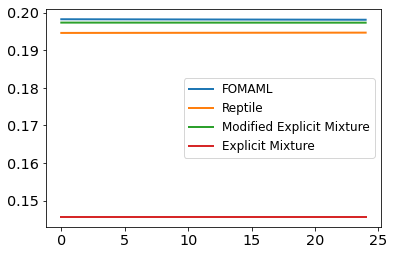

0.01 0.1 16
Running FOMAML.
Running Reptile.


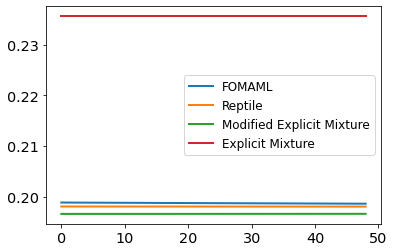

0.01 0.1 32
Running FOMAML.
Running Reptile.


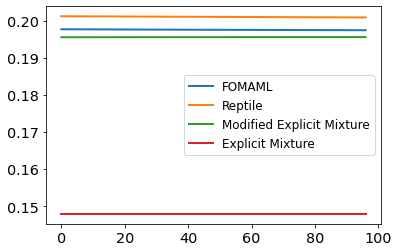

0.01 0.01 4
Running FOMAML.
Running Reptile.


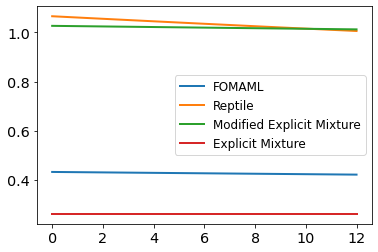

0.01 0.01 8
Running FOMAML.
Running Reptile.


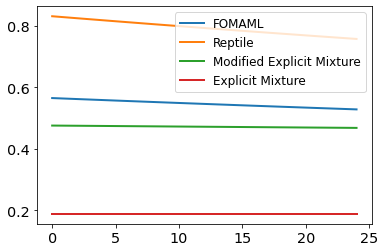

0.01 0.01 16
Running FOMAML.
Running Reptile.


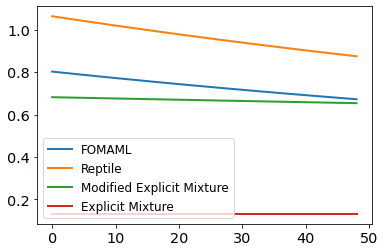

0.01 0.01 32
Running FOMAML.
Running Reptile.


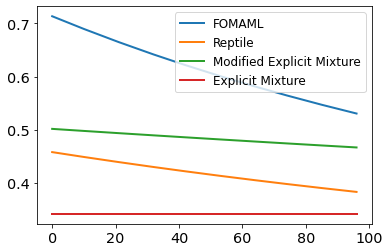

0.01 0.001 4
Running FOMAML.
Running Reptile.


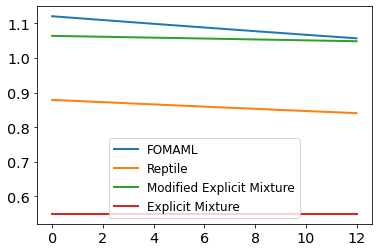

0.01 0.001 8
Running FOMAML.
Running Reptile.


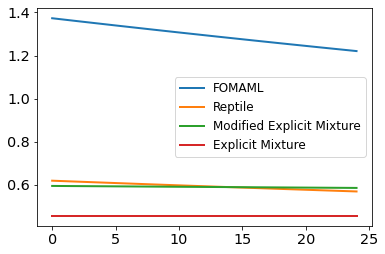

0.01 0.001 16
Running FOMAML.
Running Reptile.


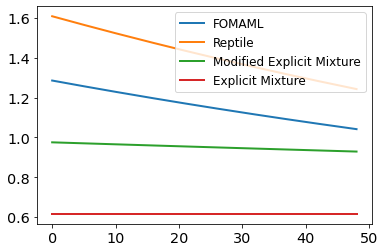

0.01 0.001 32
Running FOMAML.
Running Reptile.


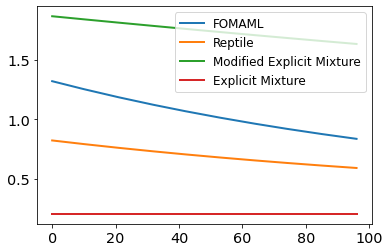

0.01 0.0001 4
Running FOMAML.
Running Reptile.


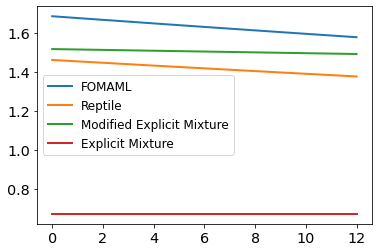

0.01 0.0001 8
Running FOMAML.
Running Reptile.


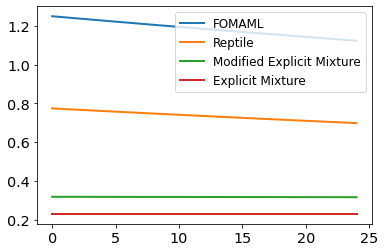

0.01 0.0001 16
Running FOMAML.
Running Reptile.


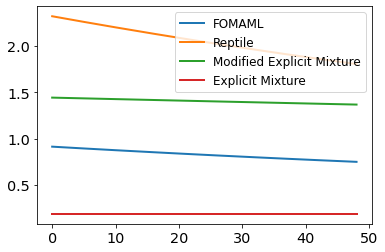

0.01 0.0001 32
Running FOMAML.
Running Reptile.


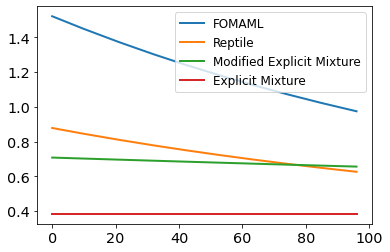

0.001 0.1 4
Running FOMAML.
Running Reptile.


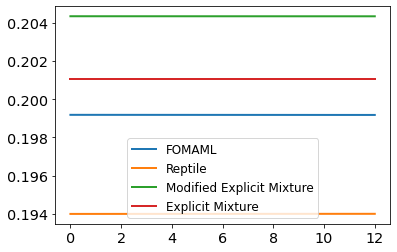

0.001 0.1 8
Running FOMAML.
Running Reptile.


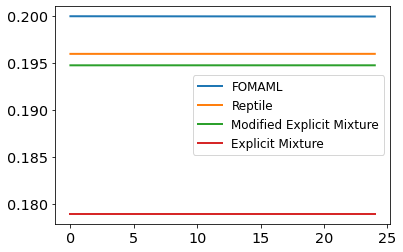

0.001 0.1 16
Running FOMAML.
Running Reptile.


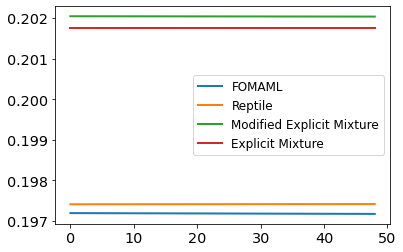

0.001 0.1 32
Running FOMAML.
Running Reptile.


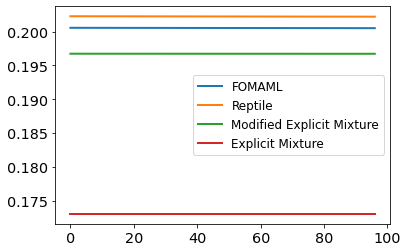

0.001 0.01 4
Running FOMAML.
Running Reptile.


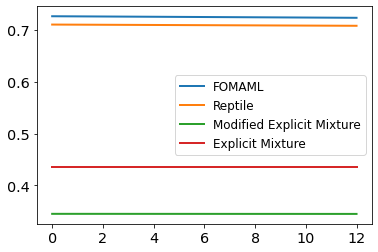

0.001 0.01 8
Running FOMAML.
Running Reptile.


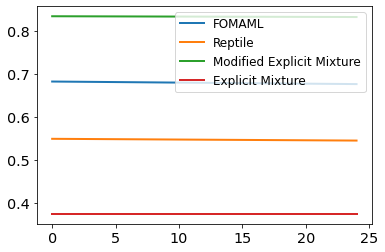

0.001 0.01 16
Running FOMAML.
Running Reptile.


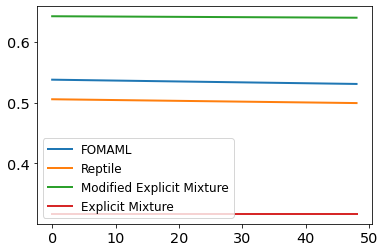

0.001 0.01 32
Running FOMAML.
Running Reptile.


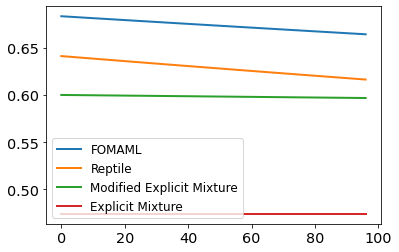

0.001 0.001 4
Running FOMAML.
Running Reptile.


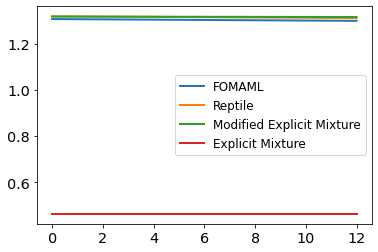

0.001 0.001 8
Running FOMAML.
Running Reptile.


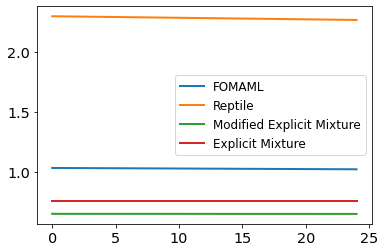

0.001 0.001 16
Running FOMAML.
Running Reptile.


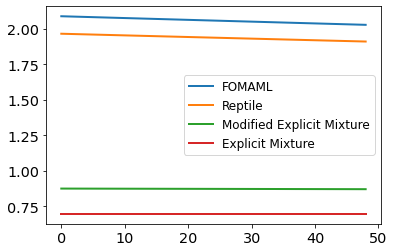

0.001 0.001 32
Running FOMAML.
Running Reptile.


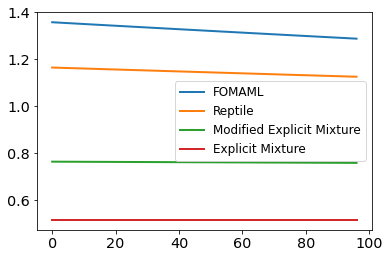

0.001 0.0001 4
Running FOMAML.
Running Reptile.


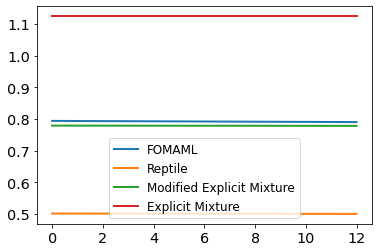

0.001 0.0001 8
Running FOMAML.
Running Reptile.


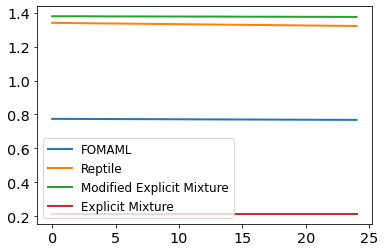

0.001 0.0001 16
Running FOMAML.
Running Reptile.


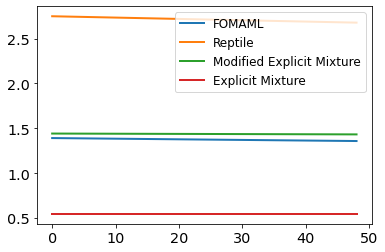

0.001 0.0001 32
Running FOMAML.
Running Reptile.


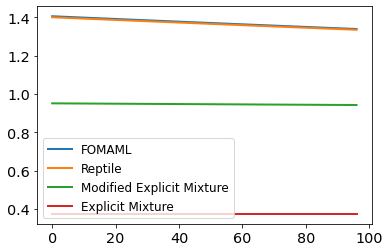

0.0001 0.1 4
Running FOMAML.
Running Reptile.


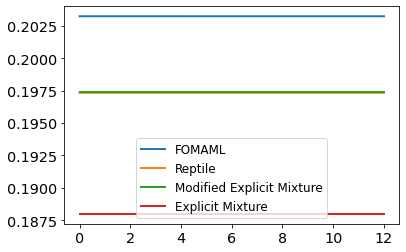

0.0001 0.1 8
Running FOMAML.
Running Reptile.


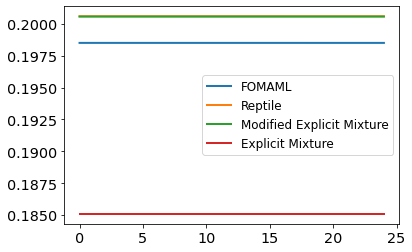

0.0001 0.1 16
Running FOMAML.
Running Reptile.


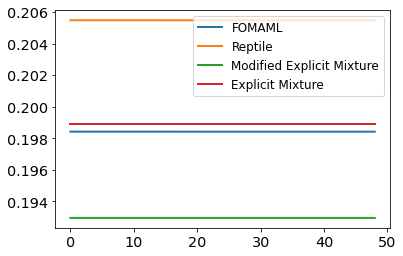

0.0001 0.1 32
Running FOMAML.
Running Reptile.


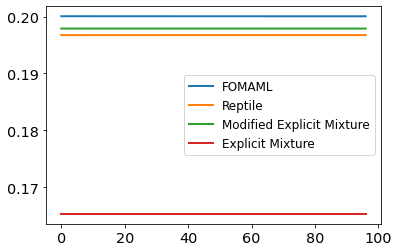

0.0001 0.01 4
Running FOMAML.
Running Reptile.


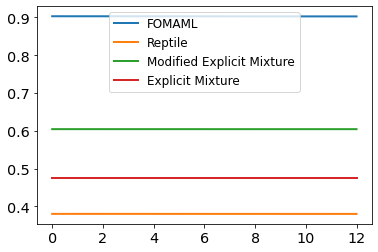

0.0001 0.01 8
Running FOMAML.
Running Reptile.


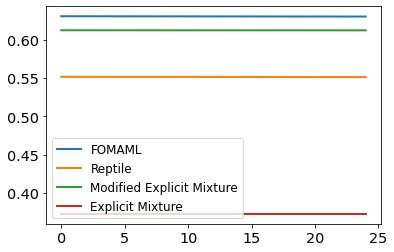

0.0001 0.01 16
Running FOMAML.
Running Reptile.


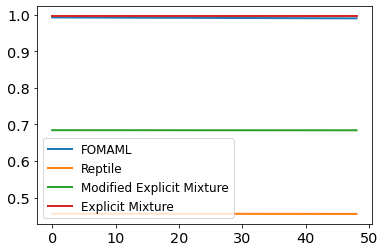

0.0001 0.01 32
Running FOMAML.
Running Reptile.


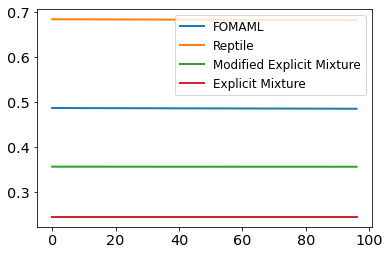

0.0001 0.001 4
Running FOMAML.
Running Reptile.


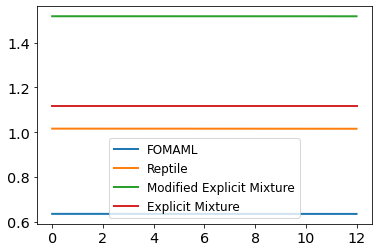

0.0001 0.001 8
Running FOMAML.
Running Reptile.


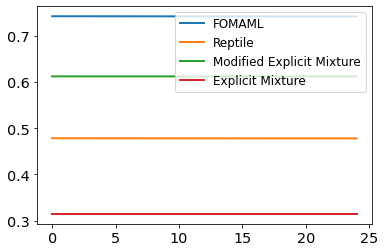

0.0001 0.001 16
Running FOMAML.
Running Reptile.


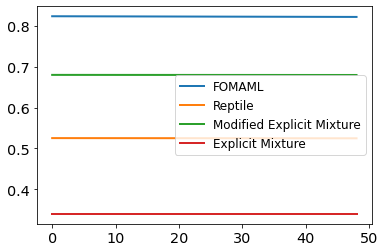

0.0001 0.001 32
Running FOMAML.
Running Reptile.


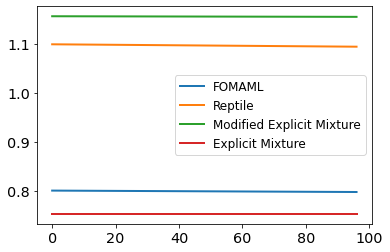

0.0001 0.0001 4
Running FOMAML.
Running Reptile.


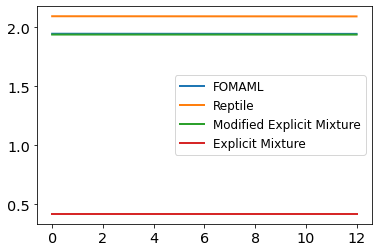

0.0001 0.0001 8
Running FOMAML.
Running Reptile.


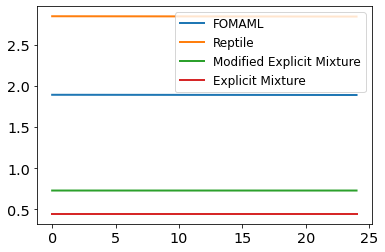

0.0001 0.0001 16
Running FOMAML.
Running Reptile.


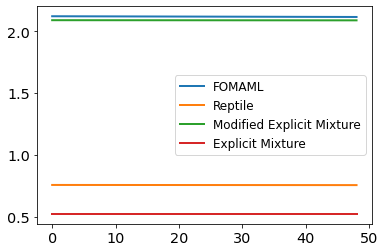

0.0001 0.0001 32
Running FOMAML.
Running Reptile.


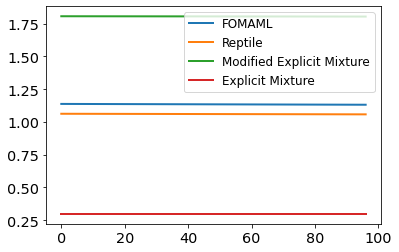

In [28]:
epochs = 50
task_batch = 4
for inner_loop_lr in inner_loop_lrs:
    for outer_loop_lr in outer_loop_lrs:
        for number_of_inner_steps in numbers_of_inner_steps:
            print(inner_loop_lr, outer_loop_lr, number_of_inner_steps)
            model_log.fomaml_inner_loop_lr = inner_loop_lr
            model_log.reptile_inner_loop_lr = inner_loop_lr
            model_log.modexpmix_inner_loop_lr = inner_loop_lr
            model_log.fomaml_outer_loop_lr = outer_loop_lr
            model_log.reptile_outer_loop_lr = outer_loop_lr
            model_log.modexpmix_outer_loop_lr = outer_loop_lr
            model_log.sgd_mixed_outer_loop = outer_loop_lr
            model_log.fomaml_number_of_inner_steps = number_of_inner_steps
            model_log.reptile_number_of_inner_steps = number_of_inner_steps
            model_log.modexpmix_number_of_inner_steps = number_of_inner_steps
            fomaml_model = model_log.fomaml(epochs=epochs, task_batch=task_batch)
            reptile_model = model_log.reptile(epochs=epochs, task_batch=task_batch)
            exp_model = model_log.sgd_mixed(epochs=epochs, task_batch=task_batch)
            modexp_model = model_log.sgd_mixed_modified(epochs=epochs, task_batch=task_batch)
            ks = np.linspace(0, number_of_inner_steps * 3, 10, dtype=int)
            loss_fomaml = np.empty(shape=(n_workers, len(ks)))
            loss_reptile = np.empty(shape=(n_workers, len(ks)))
            loss_exp = np.empty(shape=(n_workers))
            loss_modexp = np.empty(shape=(n_workers, len(ks)))
            for i in range(n_workers):
                loss_exp[i] = logreg_loss(test_data_modified[i], model_log.workers[i].compute_local(exp_model))
                for j in range(len(ks)):
                    curr_fomaml = model_local(model_log.workers[i], fomaml_model, ks[j], inner_loop_lr)
                    curr_reptile = model_local(model_log.workers[i], reptile_model, ks[j], inner_loop_lr)
                    curr_modexp = model_local_mixed(model_log.workers[i], modexp_model, ks[j], inner_loop_lr)
                    loss_fomaml[i][j] = logreg_loss(test_data_modified[i], curr_fomaml)
                    loss_reptile[i][j] = logreg_loss(test_data_modified[i], curr_reptile)
                    loss_modexp[i][j] = logreg_loss(test_data_modified[i], curr_modexp) 
            plt.plot(ks, loss_fomaml.mean(axis=0), label = 'FOMAML')
            plt.plot(ks, loss_reptile.mean(axis=0), label = 'Reptile')
            plt.plot(ks, loss_modexp.mean(axis=0), label = 'Modified Explicit Mixture')
            plt.plot(ks, [loss_exp[i].mean()] * len(ks), label = 'Explicit Mixture')
            plt.legend()
            plt.show()